# **DERIVING SPATIAL MAPS WITH PYFLWDIR in PYTHON**

## *DATA*


In [21]:
# ======= PATHS =======
Input_Root_Gis = "D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague/InputGis"
Input_Root_Julia = "D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague/OutputJulia"
Output_Root_Python = "D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague/OutputPython"

# ====== FILES NAME =======

# == Input ==
Dem_Input_Julia = "Timoleague_DEM.tiff"
River_Input = "Timoleague_River.geojson"

# == Output ==
DemCorrected_Output = "DemCorrected.tiff"
RiverOrder_Output = "RiverAll_Order.tiff"
RiverTrue_Output = "RiverAll_True.tiff"
RiverWidth_Output = "RiverAll_Width.tiff"
RiverSlope_Output = "RiverAll_Slope.tiff"

# == OUTPUT OF WFLOW ==
Ldd_Output = "Ldd.tiff"
Slope_Output = "Slope.tiff"
Subcatchment_Output = "Subcatchment.tiff"
RiverLength_Output = "RiverLength.tiff"


# ======= PARAMETERS =======

# == Ldd inputs ==
# (float, optional) Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.
Ldd_MaxDepth = -1.0

Ldd_RiverDepth = 5.0  # (float) – fixed depth value used to burn in the dem

RiverOrderMin = 2  # Depending on RiverOrder_Type

RiverWidth = 2.0  # [meters]

RiverOrder_Type = "strahler"  # <"strahler"> or <"classic">  stream order map. In the classic “bottum up” stream order map, the main river stem has order 1. Each tributary is given a number one greater than that of the river or stream into which they discharge. In the strahler “top down” stream order map, rivers of the first order are the most upstream tributaries or head water cells. If two streams of the same order merge, the resulting stream has an order of one higher. If two rivers with different stream orders merge, the resulting stream is given the maximum of the two order.

# == Other ==
NoData = 255  # Not yet applicable

Crs = 29902  # [-] This is the default projection TM65 / Irish Grid

# Outlets can be defined at edges of the grid (defualt) or force all flow to go to the minimum elevation point min. The latter only makes sense if your DEM only is masked to the catchment. Additionnally, the user can also force specific pits locations via idxs_pit.
Outlets = "edge"  # "edge","min"

# The coordinate need to be shifted such that it is in the river network, it is very sensitive
# GaugeCoordinate = [146707.700, 42167.995]
# GaugeCoordinate = [146709.504,42170.157]
GaugeCoordinate = [146708.9364, 42168.9515]


# **PLOTS**

In [22]:
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show


def PLOT_MAPS(Data, Label, Min, Max, Cmap="viridis"):
    pyplot.imshow(Data, cmap=Cmap, vmin=Min, vmax=Max)
    pyplot.title(Label)
    pyplot.colorbar(label=Label)
    pyplot.show()


## **TOOLS:**: *Reading Rivers network in geopandas*

In [23]:
import geopandas
import os as os

Path_Input_River_Geojson = os.path.join(Input_Root_Gis, River_Input)

River_Geopandas = geopandas.read_file(Path_Input_River_Geojson)
River_GeoDataFrame = geopandas.GeoDataFrame.from_features(River_Geopandas)


## **TOOLS:** *DEM -> FlowDirection (LDD)*

In [24]:
"""Note: This quick solution does require loading the entire flow direction map into memory (Flwdir_D8.load()) which can be a problem for large maps. The implementation inside hydromt_wflow works differently and makes use of options in xarray to perform computations in a chucked way (so loading only chuncks of the maps into memory to perform calculations instead of the whole map)

xarray.apply_ufunc
https://docs.xarray.dev/en/latest/generated/xarray.apply_ufunc.html

Parameters
:
                        da_elv (2D xarray.DataArray) – elevation raster

                        max_depth (float, optional) – Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.

                        Gauges ({'edge', 'min', 'idxs_pit'}) – Position of basin Gauge(s) If ‘edge’ (default) all valid elevation edge cell are considered. If ‘min’ only the global minimum elevation edge cell is considered and all flow is directed to this cell. If ‘idxs_pit’ the linear indices of the Gauge cells are provided in idxs_pit.

                        idxs_pit (1D array of int) – Linear indices of Gauge cells.

                        gdf_riv (geopandas.GeoDataArray, optional) – River vector data. If provided, the river cells are burned into the dem. Different methods can be used to burn in the river cells, see riv_burn_method.

                        riv_burn_method ({'uparea', 'rivdph', 'fixed'}, optional) – Method to burn in river vector to aid the flow direction derivation, requires gdf_riv. If ‘fixed’ (default) a fixed river depth rivdph value is used to burn in the river cells. If ‘rivdph’ the rivdph column is used to burn in the river cells directly. If ‘uparea’ the uparea column is used to create a synthetic river depth based on max(1, log10(uparea[m2])).

                        riv_depth (float) – fixed depth value used to burn in the dem

                        **kwargs – Additional keyword arguments that are passed to the pyflwdir.dem.fill_depressions() function.

"""

import hydromt
from pyflwdir.core_conversion import d8_to_ldd
import xarray
import numpy as np


def DEM_2_LDD_HYDROMT(
    Path_Input,
    Path_Output,
    Ldd_MaxDepth=Ldd_MaxDepth,
    Ldd_RiverDepth=Ldd_RiverDepth,
    NoData=NoData,
    outlets="edge",
    River=[],
):
    # Read elevation data using hydromt which will transform the data into xarray
    Dem = hydromt.io.open_raster(Path_Input)

    # Deriving the D8 from DEM
    Flwdir_D8 = hydromt.flw.d8_from_dem(
        da_elv=Dem,
        max_depth=Ldd_MaxDepth,
        gdf_riv=River,
        outlets=Outlets,
        idxs_pit=None,
        riv_burn_method="fixed",
        riv_depth=Ldd_RiverDepth,
    )

    # Converting D8-> Ldd as required by WFLOW model
    Flwdir_Ldd_Pyflwdir = xarray.apply_ufunc(d8_to_ldd, Flwdir_D8.load())

    # Save output
    Flwdir_Ldd_Pyflwdir.raster.to_raster(Path_Output, nodata=NoData)
    return Flwdir_Ldd_Pyflwdir


### ***Computting ldd***

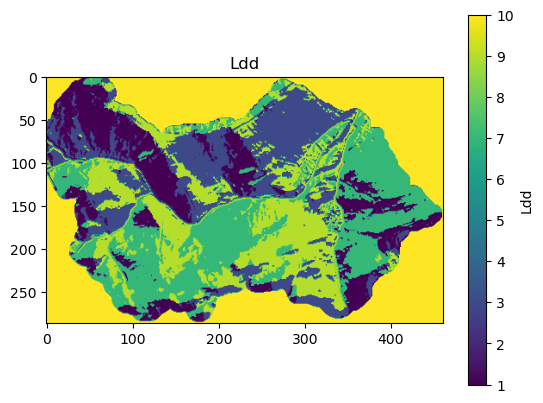

In [25]:
import os as os

Path_Input_Dem = os.path.join(Input_Root_Julia, Dem_Input_Julia)
Path_Output_Ldd = os.path.join(Output_Root_Python, Ldd_Output)

Ldd_Pyflwdir = DEM_2_LDD_HYDROMT(
    Path_Input_Dem,
    Path_Output_Ldd,
    Ldd_MaxDepth=Ldd_MaxDepth,
    Ldd_RiverDepth=Ldd_RiverDepth,
    NoData=NoData,
    outlets=Outlets,
    River=River_Geopandas
)

PLOT_MAPS(Ldd_Pyflwdir, "Ldd", 1, 10)


## **TOOL** *correcting DEM*

In [26]:
import pyflwdir
import rasterio
import os as os

"""Returns the hydrologically adjusted elevation where each downstream cell has the same or lower elevation as the current cell."""


def DEM_CORRECT(Path_Input_Dem, Path_Input_Ldd, Path_Output_DemCorrected):
    # Read uncoreccted DEM data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        Dem_Uncorrected = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    # Read D8 data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        FlowDirection_Rasterio = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    FlowDirection_Pyflwdir = pyflwdir.from_array(
        FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    # Dem_Corrected, D8 = pyflwdir.dem.fill_depressions(Dem_Uncorrected, Gauges='edge', idxs_pit=None, nodata=-9999.0, max_depth=Ldd_MaxDepth, elv_max=None, connectivity=8)

    Dem_Corrected = FlowDirection_Pyflwdir.dem_adjust(elevtn=Dem_Uncorrected)

    prof.update(dtype=rasterio.float64, nodata=False)
    with rasterio.open(Path_Output_DemCorrected, "w", **prof) as src:
        src.write(Dem_Corrected, 1)

    return Dem_Corrected


## *Running DEM corrected*

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors

Path_Input_Dem = os.path.join(Input_Root_Julia, Dem_Input_Julia)
Path_Input_Ldd = os.path.join(Output_Root_Python, Ldd_Output)
Path_Output_DemCorrected = os.path.join(
    Output_Root_Python, DemCorrected_Output)

Dem_Corrected = DEM_CORRECT(
    Path_Input_Dem, Path_Input_Ldd, Path_Output_DemCorrected)


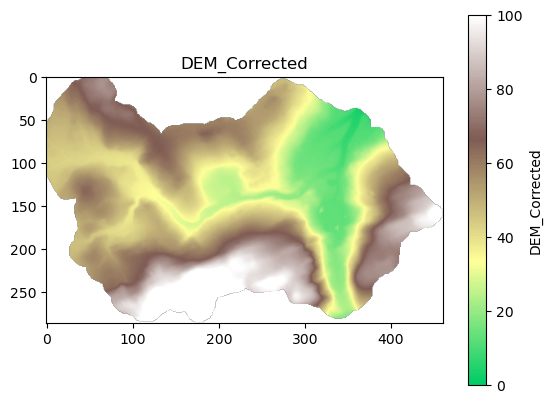

In [28]:
# PLOTTING

cmap_dem = colors.LinearSegmentedColormap.from_list(
    "dem", plt.cm.terrain(np.linspace(0.25, 1, 400))
)

norm_dem = colors.Normalize(vmin=0, vmax=100)

pyplot.imshow(Dem_Corrected, cmap=cmap_dem, norm=norm_dem)
pyplot.title("DEM_Corrected")
pyplot.colorbar(label="DEM_Corrected")


## **TOOLS:** *DEM -> SLOPE*

In [29]:
import rasterio
import pyflwdir


def DEM_2_SLOPE(Path_Input_Dem, Path_Output_Slope):
    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        elevtn = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    Slope_Pyflwdir = pyflwdir.dem.slope(
        elevtn, nodata=src.nodata, latlon=latlon, transform=transform
    )

    # Write to tiff file
    prof.update(dtype=Slope_Pyflwdir.dtype, nodata=False)
    with rasterio.open(Path_Output_Slope, "w", **prof) as src:
        src.write(Slope_Pyflwdir, 1)

    return Slope_Pyflwdir


### ***Computting Slope***

In [30]:
import os as os

Path_Input_DemCorrected = os.path.join(Output_Root_Python, DemCorrected_Output)
Path_Output_Slope = os.path.join(Output_Root_Python, Slope_Output)

Slope_Pyflwdir = DEM_2_SLOPE(Path_Input_DemCorrected, Path_Output_Slope)


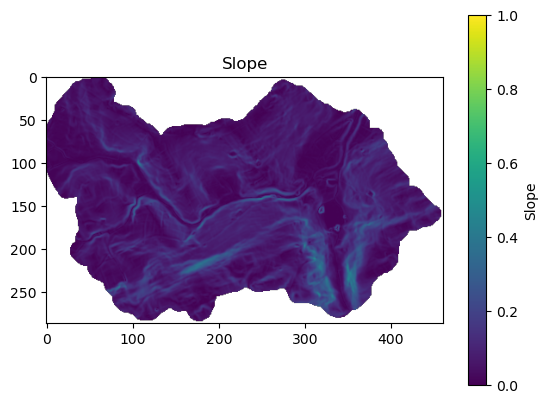

In [31]:
PLOT_MAPS(Slope_Pyflwdir, "Slope", 0, 1.0)


## **TOOLS:** *FlowDirection -> Streams*


In [32]:
import rasterio
import pyflwdir
import numpy as np


def FLOWDIRECTION_2_STREAMS(
    FlowDirection_Pyflwdir,
    Path_Input_Dem,
    Path_Input_Ldd,
    Path_Output_RiverOrder,
    Path_Output_RiverSlope,
    Path_Output_RiverWidth,
    Path_Output_RiverTrue,
    Slope_Pyflwdir,
    RiverOrderMin,
    RiverWidth,
    Type,
):
    #  Type= "strahler" or "classic"

    # Read elevation data using rasterio just for initialisation
    with rasterio.open(Path_Input_Dem, "r") as src:
        elevtn = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    # === STREAM ORDERS ===================================

    # Read D8 data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        FlowDirection_Rasterio = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    FlowDirection_Pyflwdir = pyflwdir.from_array(
        FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    # River order
    Rivers_RiverOrder0 = FlowDirection_Pyflwdir.stream_order(type=Type)

    # Masking data were River order > 1
    Nx, Ny = np.shape(Rivers_RiverOrder0)
    Rivers_RiverOrder = np.ma.empty(shape=(Nx, Ny))
    for iX in range(Nx):
        for iY in range(Ny):
            if Rivers_RiverOrder0[iX, iY] >= RiverOrderMin:
                Rivers_RiverOrder[iX, iY] = Rivers_RiverOrder0[iX, iY]
            else:
                Rivers_RiverOrder[iX, iY] = np.nan

    prof.update(dtype=rasterio.int64, nodata=False)
    with rasterio.open(Path_Output_RiverOrder, "w", **prof) as src:
        src.write(Rivers_RiverOrder, 1)

    # === STREAMS TRUE ==================================
    Rivers_True = np.greater(Rivers_RiverOrder, RiverOrderMin)

    prof.update(dtype=rasterio.int64, nodata=False)
    with rasterio.open(Path_Output_RiverTrue, "w", **prof) as src:
        src.write(Rivers_True, True)

    # === STREAMS WIDTH ===
    Rivers_Width = Rivers_True * RiverWidth
    prof.update(dtype=rasterio.float64, nodata=False)
    with rasterio.open(Path_Output_RiverWidth, "w", **prof) as src:
        src.write(Rivers_Width, 1)

    # === STREAM SLOPE ====
    Nx, Ny = np.shape(Rivers_True)
    Rivers_Slope = np.ma.empty(shape=(Nx, Ny))

    # Masking only data were we have slope
    for iX in range(Nx):
        for iY in range(Ny):
            if Rivers_True[iX, iY] == True:
                Rivers_Slope[iX, iY] = Slope_Pyflwdir[iX, iY]

    prof.update(dtype=rasterio.float64, nodata=False)
    with rasterio.open(Path_Output_RiverSlope, "w", **prof) as src:
        src.write(Rivers_Slope, 1)

    return Rivers_True, Rivers_Slope, Rivers_RiverOrder, Rivers_Width


### ***Computting Streams***

In [33]:
Path_Input_Ldd = os.path.join(Output_Root_Python, Ldd_Output)
Path_Output_RiverOrder = os.path.join(Output_Root_Python, RiverOrder_Output)
Path_Output_RiverSlope = os.path.join(Output_Root_Python, RiverSlope_Output)
Path_Output_RiverWidth = os.path.join(Output_Root_Python, RiverWidth_Output)
Path_Output_RiverTrue = os.path.join(Output_Root_Python, RiverTrue_Output)

Rivers_True, Rivers_Slope, Rivers_RiverOrder, Rivers_Width = FLOWDIRECTION_2_STREAMS(
    Ldd_Pyflwdir,
    Path_Input_Dem,
    Path_Input_Ldd,
    Path_Output_RiverOrder,
    Path_Output_RiverSlope,
    Path_Output_RiverWidth,
    Path_Output_RiverTrue,
    Slope_Pyflwdir,
    RiverOrderMin=RiverOrderMin,
    RiverWidth=RiverWidth,
    Type=RiverOrder_Type,
)


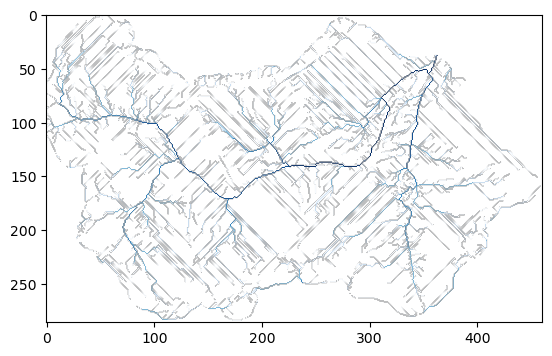

In [34]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors

pyplot.imshow(Rivers_RiverOrder, cmap=colors.ListedColormap(
    cm.Blues(np.linspace(0, 1, 10))))


## **TOOLS:** *FlowDirections -> Catchements*

In [35]:
# import geopandas as gpd
import numpy as np
import geopandas as gpd
import rasterio
import pyflwdir

# import python_utils
import os as os


def FLOWDIRECTION_2_CATCHEMENT(
    GaugeCoordinate,
    Path_Input_Ldd,
    Path_Output_Subcatchment,
):
    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        flwdir = src.read(1)
        transform = src.transform
        crs = src.crs
        latlon = crs.is_geographic
        prof = src.profile

    flw = pyflwdir.from_array(
        flwdir, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    # Define output locations
    X, Y = np.array([GaugeCoordinate[0]]), np.array([GaugeCoordinate[1]])

    # delineate subbasins
    Subcatchment_Pyflwdir = flw.basins(
        xy=(X, Y), streams=flw.stream_order() >= 8)

    print(flwdir.dtype)

    prof.update(dtype=flwdir.dtype, nodata=False)
    with rasterio.open(Path_Output_Subcatchment, "w", **prof) as src:
        src.write(Subcatchment_Pyflwdir, 1)

    return Subcatchment_Pyflwdir


## ***Computing catchments***

If you have no map than this may be due that GaugeCoordinate is not on a river network
uint8


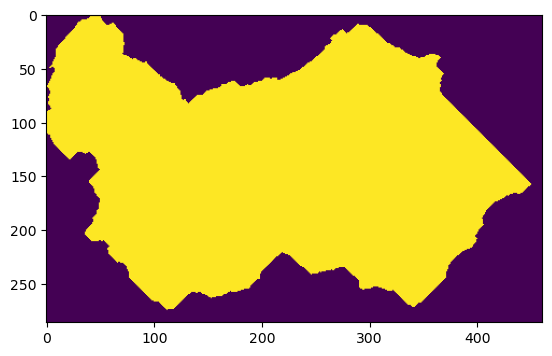

In [36]:
# Warning: GaugeCoordinate
import os as os

Path_Input_Ldd = os.path.join(Output_Root_Python, Ldd_Output)
Path_Output_Subcatchment = os.path.join(
    Output_Root_Python, Subcatchment_Output)

print("If you have no map than this may be due that GaugeCoordinate is not on a river network")

Subcatchment_Pyflwdir = FLOWDIRECTION_2_CATCHEMENT(
    GaugeCoordinate, Path_Input_Ldd, Path_Output_Subcatchment)

pyplot.imshow(Subcatchment_Pyflwdir)


## **TOOLS**: *RiverLength*

In [37]:
""" Returns the subgrid river length [m] based on unit catchment Gauge locations.
        A cell's subgrid river is defined by the path starting at the unit
        catchment Gauge pixel moving up- or downstream until it reaches the next
        Gauge pixel. If moving upstream and a pixel has multiple upstream neighbors,
        the pixel with the largest upstream area is selected.

        Parameters
        ----------
        idxs_out : 2D array of int
            Linear indices of unit catchment Gauges. If None (default) the cell
            size (instead of subgrid length) will be used.
        mask : 2D array of bool with self.shape, optional
            True for valid pixels. can be used to mask out pixels of small rivers.
        direction : {"up", "down"}
            Flow direction in which river length is measured, by default 'up'.
        unit : {'m', 'cell'}
            Upstream area unit.

        Returns
        -------
        rivlen : 2D array of float with idxs_out.shape
            subgrid river length [m]
        """

import pyflwdir


def RIVER_LENGTH(Path_Input_Ldd, Path_Output_RiverLength):
    # # Read the Rivers_True
    # with rasterio.open(Path_River_True, "r") as src:
    #    River_True = src.read(1)
    #    transform=src.transform
    #    crs = src.crs
    #    latlon=crs.is_geographic
    #    prof = src.profile

    # Read D8 data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        FlowDirection_Rasterio = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    FlowDirection_Pyflwdir = pyflwdir.from_array(
        FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    River_Length = FlowDirection_Pyflwdir.subgrid_rivlen(
        idxs_out=None, mask=None, direction='up', unit='m')

    prof.update(dtype=rasterio.float64, nodata=False)
    with rasterio.open(Path_Output_RiverLength, "w", **prof) as src:
        src.write(River_Length, 1)

    return River_Length


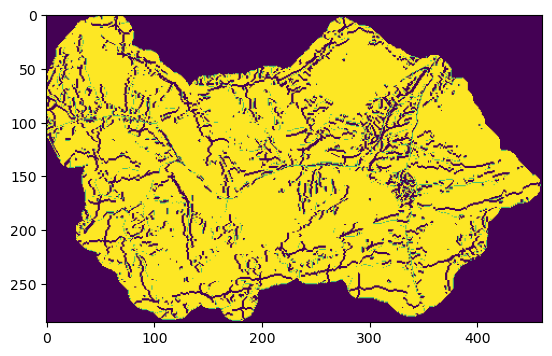

In [38]:
Path_Output_Ldd = os.path.join(Output_Root_Python, Ldd_Output)
Path_Output_RiverLength = os.path.join(Output_Root_Python, RiverLength_Output)
# Path_River_True = os.path.join(Output_Root_Python, RiverTrue_Output)

River_Length = RIVER_LENGTH(Path_Input_Ldd, Path_Output_RiverLength)

pyplot.imshow(River_Length)



# =========================================================================================================

# OLD CODE

In [39]:
import hydromt
import pyflwdir
import rasterio


def DEM_2_LDD_HYDROMT0(Path_Input, Path_Output, Ldd_MaxDepth=-1.0, Gauges="edge"):
    # Read elevation data using hydromt which will transform the data into xarray
    Dem = hydromt.io.open_raster(Path_Input)

    Flwdir_D8 = hydromt.flw.d8_from_dem(
        Dem, max_depth=Ldd_MaxDepth, Gauges=Gauges, idxs_pit=None
    )

    Flwdir_D8.raster.to_raster(Path_Output)

    # Read D8 data using rasterio
    with rasterio.open(Path_Output, "r") as src:
        D8 = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    # Converting D8 -> ldd
    Flwdir_Ldd_Pyflwdir = pyflwdir.core_conversion.d8_to_ldd(D8)

    # Write to tiff file
    prof.update(dtype=Flwdir_Ldd_Pyflwdir.dtype, nodata=False)
    with rasterio.open(Path_Output, "w", **prof) as src:
        src.write(Flwdir_Ldd_Pyflwdir, 1)

    return Flwdir_Ldd_Pyflwdir


In [40]:
import rasterio
import numpy as np
import pyflwdir


def DEM_2_LDD_PYFLWDIR(
    Path_Input_Dem, Path_Output_FlowDirection, Ldd_MaxDepth=-1.0, Gauges="edge"
):
    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        elevtn = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    # returns FlwDirRaster object
    Ldd_Pyflwdir = pyflwdir.from_dem(
        data=elevtn,
        nodata=src.nodata,
        max_depth=Ldd_MaxDepth,
        Gauges=Gauges,
        transform=transform,
        latlon=latlon,
    )

    Ldd_Array = Ldd_Pyflwdir.to_array(ftype="ldd")

    # Write to tiff file
    prof.update(dtype=Ldd_Array.dtype, nodata=False)
    with rasterio.open(Path_Output_FlowDirection, "w", **prof) as src:
        src.write(Ldd_Array, 1)

    return Ldd_Pyflwdir, Ldd_Array
